# YouTube URL Analysis

## Preface
### Data descriptions

In [1]:
#sample_size = 100000000 # specifies the sample size
sample_size = 100000000 # specifies the sample size
limit = 15  # specifies the number of elements in lists and graphs
n_cores = 6 # number of cores to use for parallelization

url_columns = ["id", "hash", "channelId", "publishedAt", "url", "resolvedUrl", "domain","resolved","dead","status_code"]
video_columns = ["id","hash","channelId","channelTitle","publishedAt","title","description","tags","categoryId","defaultLanguage","defaultAudioLanguage","duration","dimension","definition","caption","licensedContent","allowedIn","blockedIn","viewCount","likeCount","dislikeCount","favoriteCount","commentCount","requesttime"]
channel_columns = ["id","title","description","subscriberCount","videoCount","commentCount","viewCount","featuring","subscribing","country","publishedAt","daysactive","keywords","topics","wikitopics"]

### Import necessary modules

In [2]:
import numpy as np
import pandas as pd
import csv
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(14,8.27)})
from multiprocessing import Pool
import os, gc
import re

### Load data

In [3]:
# load URLs csv
pd_url_data = pd.read_csv('sample_' + str(sample_size) + '.csv', names=url_columns)
pd_url_data.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000000 entries, 0 to 99999999
Columns: 10 entries, id to status_code
dtypes: float64(1), int64(3), object(6)
memory usage: 47.2 GB


In [4]:
# get rid of columns we don't need
pd_url_data = pd_url_data[["id", "hash", "channelId", "publishedAt","resolvedUrl", "resolved","dead"]]
pd_url_data.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000000 entries, 0 to 99999999
Columns: 7 entries, id to dead
dtypes: int64(3), object(4)
memory usage: 32.0 GB


In [5]:
# cast columns in right type
pd_url_data['date'] = pd.to_datetime(pd_url_data["publishedAt"]).dt.date
pd_url_data['year'] = pd.to_datetime(pd_url_data["publishedAt"]).dt.year

# skip everything before 1 december 2019
pd_url_data = pd_url_data[pd_url_data['date'] < datetime.date(year=2019, month=12, day=1)]
print("min date: %s, max date: %s\n" % (min(pd_url_data.date),max(pd_url_data.date)))

pd_url_data.info(verbose=False, memory_usage="deep")

min date: 2005-10-24, max date: 2019-11-30

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98836872 entries, 0 to 99999999
Columns: 9 entries, id to year
dtypes: int64(4), object(5)
memory usage: 36.8 GB


### Check 'dead' URLs + how many have not yet been checked 
When less than 5%, just leave it as is

@todo: too many unchecked URLs

In [6]:
# count URLs marked as dead on expansion
pd_url_data_dead = len(pd_url_data.query("dead==1"))
# count total number of URLs
total = len(pd_url_data)
# calculate percentage
percent_dead = round(pd_url_data_dead/total*100,2) 
# print percentage
print("Total URLS: %s, of which %s (%s%%) dead" % (total, pd_url_data_dead, percent_dead))

# unchecked if resolved = 0 and dead = 0
pd_url_data_unchecked = len(pd_url_data.query('resolved==0 & dead==0'))
percent_unchecked = round(pd_url_data_unchecked/total*100,2)
print("Total URLS: %s, of which %s (%s%%) NOT yet checked" % (total, pd_url_data_unchecked, percent_unchecked))

# get rid of columns we don't need
pd_url_data = pd_url_data[["id", "hash", "channelId", "year","resolvedUrl"]]

# free up even more memory
del pd_url_data_dead
del pd_url_data_unchecked
gc.collect()

pd_url_data.info(verbose=False, memory_usage="deep")

Total URLS: 98836872, of which 3486949 (3.53%) dead
Total URLS: 98836872, of which 12210085 (12.35%) NOT yet checked
<class 'pandas.core.frame.DataFrame'>
Int64Index: 98836872 entries, 0 to 99999999
Columns: 5 entries, id to resolvedUrl
dtypes: int64(2), object(3)
memory usage: 24.6 GB


### Clean data

In [7]:
# load list of icann tlds and stlds
from icann_domains import icann_domains
pd_icann_domains = pd.Series(icann_domains)
pd_icann_domains_stld = pd_icann_domains[pd_icann_domains.str.contains("\.")]  # filter for second/third/... level tld
pd_icann_domains_stld = '.' + pd_icann_domains_stld.astype(str) # make sure we will filter on stld, rather than part of domain


In [9]:
# function that checks whether a URL ends with an icann stld and extracts proper host name
# @todo, super costly function. See whether it can be improved
def get_host(url):
    try:
        if url.endswith(tuple(pd_icann_domains_stld)): # check whether url ends in stld
            stld_found = next((stld for stld in pd_icann_domains_stld if url.endswith(str(stld))), None)  # find which stld it ends with
            if stld_found is not None:
                return re.sub(".*?([^.]+\\" + stld_found + ")$", r"\1", url)  # get host as non-dotted word before (and incl) stld
            else:
                return re.sub('.*?([^.]+\.[^.]+)$', r"\1", url)
        else:
            return re.sub('.*?([^.]+\.[^.]+)$', r"\1", url)
    except:
        return ''

def clean_data_wrapped(df):
    try:
        return clean_data(df)
    except:
        print("%s Except in clean_data_wrapped"%(now_string()))
        return False # @todo, warning this is just for testing!

def now_string():
    return datetime.datetime.now().strftime("%H:%M:%S")

'''
# function to clean data: clean up URLs, remove slashes, extract host
def clean_data(df):
    
    print("%s pid child %s length = %s" % (now_string(), os.getpid(), len(df)))

    # remove trailing slash
    df.replace({'resolvedUrl': r'/\)?$'}, {'resolvedUrl':''}, regex=True, inplace=True)

    # override domain from URL extraction
    df['domain'] = df['resolvedUrl'].replace('https?://([^/:#]+).*', r'\1', regex=True)  # extract full domain (don't rely on extracted stuff in db)
    print("%s pid child %s cleaned URLs"%(now_string(), os.getpid()))

    # remove all www. or www2.
    df.replace({'domain': r'^www2?\.'}, {'domain': ''}, regex=True, inplace=True)

    # replace common abbreviations
    df.replace({'domain': 'youtu.be'}, {'domain': 'youtube.com'}, regex=True, inplace=True)
    df.replace({'domain': 'fb.com'}, {'domain': 'facebook.com'}, regex=True, inplace=True)
    df.replace({'domain': 'm.facebook.com'}, {'domain': 'facebook.com'}, regex=True, inplace=True)
    # df.replace({'domain': r'^open\.spotify'}, {'domain': 'spotify'}, regex=True, inplace=True)
    print("%s pid child %s domain replacements"%(now_string(), os.getpid()))    

    # get host based on icann (s)tlds
    df['host'] = df['domain'].apply(get_host)

    print("%s pid child %s done host"%(now_string(), os.getpid()))

    return df
'''

# remove trailing slash
pd_url_data.replace({'resolvedUrl': r'/\)?$'}, {'resolvedUrl':''}, regex=True, inplace=True)

# override domain from URL extraction
pd_url_data['domain'] = pd_url_data['resolvedUrl'].replace('https?://([^/:#]+).*', r'\1', regex=True)  # extract full domain (don't rely on extracted stuff in db)
print("%s pid child %s cleaned URLs"%(now_string(), os.getpid()))

# remove all www. or www2.
pd_url_data.replace({'domain': r'^www2?\.'}, {'domain': ''}, regex=True, inplace=True)

# @todo, lower all domains

# replace common abbreviations
pd_url_data.replace({'domain': 'youtu.be'}, {'domain': 'youtube.com'}, regex=True, inplace=True)
pd_url_data.replace({'domain': 'fb.com'}, {'domain': 'facebook.com'}, regex=True, inplace=True)
pd_url_data.replace({'domain': 'm.facebook.com'}, {'domain': 'facebook.com'}, regex=True, inplace=True)
# df.replace({'domain': r'^open\.spotify'}, {'domain': 'spotify'}, regex=True, inplace=True)
print("%s pid child %s domain replacements"%(now_string(), os.getpid()))    

# get host based on icann (s)tlds
# @todo, consider a new monetization strategy (e.g. endswith on the hosts in commission list)
pd_url_data['host'] = pd_url_data['domain'].apply(get_host)

print("%s pid child %s done host"%(now_string(), os.getpid()))

# function to parallelize dataframe computation
def parallelize_dataframe(df, func, n_cores):
    # split data frame
    df.info(verbose=False, memory_usage="deep")
    df_split = np.array_split(df, n_cores)
    df = pd.DataFrame()
    df.info(verbose=False, memory_usage="deep")

    # start multi-processing
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    print("join length %s" % (len(df)))
    pool.close()
    pool.join()
    return df

#print("start length %s"%(len(pd_url_data)))
#pd_url_data = parallelize_dataframe(pd_url_data, clean_data_wrapped, n_cores)

10:30:08 pid child 13971 cleaned URLs
10:37:53 pid child 13971 domain replacements
00:03:42 pid child 13971 done host


# Generic analysis

In [10]:
print("Basic stats on int/float columns")
print(pd_url_data.describe())

Basic stats on int/float columns
                 id          year
count  9.883687e+07  9.883687e+07
mean   2.888667e+08  2.016876e+03
std    1.667982e+08  2.013434e+00
min    1.000000e+00  2.005000e+03
25%    1.443845e+08  2.016000e+03
50%    2.889072e+08  2.017000e+03
75%    4.333157e+08  2.018000e+03
max    5.777381e+08  2.019000e+03


## Basic stats (based on videos, not channels)
### Top domains

In [11]:
# add count column
pd_url_data['count'] = 1 
# count domains in URLs data set and sort in reverse
pd_url_data_groupedDomain = pd_url_data.groupby(["domain"]).count()['count'].sort_values(ascending=False).reset_index()
# print header
print("Top %s domains" % (limit)) 
# print most used domains overall
print(pd_url_data_groupedDomain.head(limit)) 

Top 15 domains
                 domain     count
0           youtube.com  31413621
1          facebook.com  11223932
2           twitter.com   9031377
3         instagram.com   5326574
4       plus.google.com   1330601
5       play.google.com   1008616
6             twitch.tv    935870
7                vk.com    924552
8        soundcloud.com    533813
9            amazon.com    470323
10  accounts.google.com    439276
11     itunes.apple.com    417403
12          patreon.com    372540
13        pinterest.com    349942
14            amazon.de    274459


### Top hosts

In [12]:
# add count column
pd_url_data['count'] = 1 
# count hosts in URLs data set and sort in reverse
pd_url_data_groupedHost = pd_url_data.groupby(["host"]).count()['count'].sort_values(ascending=False).reset_index()
pd_url_data_groupedHost = pd_url_data_groupedHost[pd_url_data_groupedHost['host']!=""] # remove empty for as of yet unresolved URLs
# print header
print("Top %s hosts" % (limit)) 
# print most used domains overall
print(pd_url_data_groupedHost.head(limit)) 

Top 15 hosts
              host     count
0      youtube.com  31491443
2     facebook.com  11318163
3      twitter.com   9054212
4    instagram.com   5327937
5       google.com   3135395
6        twitch.tv    977480
7           vk.com    934677
8        apple.com    752031
9   soundcloud.com    535736
10      amazon.com    477142
11   pinterest.com    415530
12     patreon.com    372568
13       amazon.de    274774
14      tumblr.com    273115
15      discord.gg    256262


### Top deep links

In [13]:
# reset count column
pd_url_data['count'] = 1 
# count resolved deep links in URLs data set and sort in reverse
pd_url_data_groupedUrl = pd_url_data.groupby(["resolvedUrl"]).count()['count'].sort_values(ascending=False).reset_index() 
# print header
print("Top %s resolvedUrl" % (limit)) 
# print most used deep links
print(pd_url_data_groupedUrl.head(limit))

# free up memory
del pd_url_data_groupedUrl
gc.collect()

Top 15 resolvedUrl
                                          resolvedUrl   count
0                                https://www.zee5.com  113865
1               https://www.youtube.com/error?src=404   81582
2                   https://unacademy.com/unavailable   77940
3   https://www.youtube.com/user/euronewsnetwork/c...   73520
4                              http://incompetech.com   71485
5                   https://www.facebook.com/euronews   68619
6         https://creativecommons.org/licenses/by/4.0   61754
7            https://www.youtube.com/playlist?list...   54079
8                      https://www.instagram.com/zee5   51265
9                       https://twitter.com/ZEE5India   50696
10                      https://www.facebook.com/ZEE5   50409
11         http://creativecommons.org/licenses/by/3.0   48785
12                       http://www.epidemicsound.com   46968
13            https://datinglogic.net/forums/forum/qa   45200
14      https://onlinedatinglogic.com/forums/forum/

60

### Top TLDs

In [14]:
# reset count column
pd_url_data['count'] = 1 
# make TLD column based on domain
pd_url_data['tld'] = pd_url_data['domain'].str.replace('^.*\.', '', regex=True) # @todo, could also do based on icann_domains
# count TLDs used and sort in reverse
pd_url_data_groupedTld = pd_url_data.groupby(["tld"]).count()['count'].sort_values(ascending=False).reset_index()
# print header
print("Top %s TLDs" % (limit))
# print most used TLDs
print(pd_url_data_groupedTld.head(limit))

Top 15 TLDs
    tld     count
0   com  74273927
1    tv   1676363
2   net    654025
3    in    489721
4    de    489520
5   org    479761
6    me    395788
7    ru    368813
8    br    320577
9    kr    291582
10   gg    273084
11   jp    210757
12   co    206607
13   st    192968
14   uk    168192


### Top domains per TLD

In [15]:
# for each tld, get limit domain
print("Top domains per TLD")
for tld in pd_url_data_groupedTld.head(limit)['tld']:
    top_domains_for_tld = pd_url_data[pd_url_data['tld']==tld].groupby(['tld','domain'])['hash'].nunique().sort_values(ascending=False)
    print(top_domains_for_tld[:limit])

# free up mmemory
del pd_url_data_groupedTld
del top_domains_for_tld
gc.collect()

Top domains per TLD
tld  domain             
com  youtube.com            19389193
     facebook.com           10749341
     twitter.com             8764278
     instagram.com           5131699
     plus.google.com         1322576
     play.google.com          981756
     vk.com                   850177
     soundcloud.com           489324
     accounts.google.com      435304
     itunes.apple.com         398494
     patreon.com              368475
     pinterest.com            346796
     amazon.com               334508
     apps.apple.com           266511
     google.com               208721
Name: hash, dtype: int64
tld  domain         
tv   twitch.tv          850550
     tfc.tv              19677
     espreso.tv          17499
     ruptly.tv           17150
     ns7.tv              17044
     lahorenews.tv       15130
     britishpathe.tv     14328
     sathiyam.tv         14241
     qazaqstan.tv        14140
     beritasatu.tv       13613
     city42.tv           13154
     samaa.tv

0

# Monetization

## Allowed merch and monetization on Github
https://support.google.com/youtube/answer/6083754?hl=en#zippy=%2Clist-of-approved-merchandise-sites

In [16]:
# import merch and crowd lists
from allowed_3rdparty import merch, crowd
print("Number of merch sites: %s" % (len(merch)))
print("Number of crowd sites: %s" % (len(crowd)))

# add boolean column to pd_url_data based on presence in lists
pd_url_data["crowd"] = np.where(pd_url_data["domain"].isin(crowd), True, False)
pd_url_data["merch"] = np.where(pd_url_data["domain"].isin(merch), True, False)

Number of merch sites: 191
Number of crowd sites: 85


## Commission
According to Oscar's classification and including Paypal, skillshare, banggood and aliexpress

*Warning:* This is done on host, rather than domain (as too much happened in subdomains)


In [17]:
from allowed_3rdparty import commission, commission_extra
print("Number of commission sites: %s" % (len(commission)))
print("Number of commission_extra sites: %s" % (len(commission_extra)))

# add boolean column to pd_url_data based on presence in lists
pd_url_data["commission"] = np.where(pd_url_data["host"].isin(commission), True, False) 
pd_url_data["commission_extra"] = np.where(pd_url_data["host"].isin(commission_extra), True, False) 

Number of commission sites: 83
Number of commission_extra sites: 7


In [18]:
# find possible extra commission domains 
'''
pd_url_data['count'] = 1 # reset count column
commission_domains = pd_url_data[pd_url_data.host.str.contains('amazon\.|amazonaws|getshirts|airbnb|movavi|audible|joinhoney|twitch|tripadvisor|shopstyle|adobe|sellfy|clickfunnels|clickbank|etsy|bluehost|shareasale|hubspot|sendinblue|rakutenmarketing|adworkmedia|jvzoo|markethealth|maxbounty|ebay|bhcosmetics|affiliateprograms|sigma-beauty|shopify|agoda|jimpartners|ipage|\.media\.net|leadpages', regex=True, na=False)].groupby('host').count()['count'].sort_values(ascending=False).reset_index()
print("Possible extra commission:")
for row in commissiondomains['host']:
    if row not in commission:
        print("'%s'," % row)
print("")

pd_url_data['count'] = 1 # reset count column
commission_domains_extra = pd_url_data[pd_url_data.host.str.contains('banggood|aliexpress|paypal|skillshare', regex= True, na=False)].groupby('host').count()['count'].sort_values(ascending=False).reset_index()
print("Possible extra commission extra:")
for row in commission_domains_extra['host']:
    if row not in commission_extra:
        print("'%s',"%row)
print("")
'''

'\npd_url_data[\'count\'] = 1 # reset count column\ncommission_domains = pd_url_data[pd_url_data.host.str.contains(\'amazon\\.|amazonaws|getshirts|airbnb|movavi|audible|joinhoney|twitch|tripadvisor|shopstyle|adobe|sellfy|clickfunnels|clickbank|etsy|bluehost|shareasale|hubspot|sendinblue|rakutenmarketing|adworkmedia|jvzoo|markethealth|maxbounty|ebay|bhcosmetics|affiliateprograms|sigma-beauty|shopify|agoda|jimpartners|ipage|\\.media\\.net|leadpages\', regex=True, na=False)].groupby(\'host\').count()[\'count\'].sort_values(ascending=False).reset_index()\nprint("Possible extra commission:")\nfor row in commissiondomains[\'host\']:\n    if row not in commission:\n        print("\'%s\'," % row)\nprint("")\n\npd_url_data[\'count\'] = 1 # reset count column\ncommission_domains_extra = pd_url_data[pd_url_data.host.str.contains(\'banggood|aliexpress|paypal|skillshare\', regex= True, na=False)].groupby(\'host\').count()[\'count\'].sort_values(ascending=False).reset_index()\nprint("Possible extra 

## Save monetization info to csv for grounded coding

In [19]:
# merge domain count with pd_url_data
pd_url_data_merch_cats = pd_url_data[['domain', 'crowd', 'merch', 'commission', 'commission_extra']] #.query('crowd==True | merch==True | commission==True | commission_extra==True')
pd_url_data_merch_cats = pd_url_data_groupedDomain.merge(pd_url_data_merch_cats, on='domain', how='left')
pd_url_data_merch_cats = pd_url_data_merch_cats.drop_duplicates()
# make category descriptions
pd_url_data_merch_cats = pd_url_data_merch_cats.replace({'crowd': {True: 'crowd', False: ''}, 'merch': {True: 'merch', False: ''}, 'commission': {True: 'commission', False: ''}, 'commission_extra': {True: 'extra', False: ''}})
cats = pd_url_data_merch_cats['crowd']+pd_url_data_merch_cats['merch']+pd_url_data_merch_cats['commission']+pd_url_data_merch_cats['commission_extra']
pd_url_data_merch_cats['category'] = cats
pd_url_data_merch_cats = pd_url_data_merch_cats.drop(['crowd', 'merch', 'commission', 'commission_extra'], axis=1)
print(pd_url_data_merch_cats.head(10))
# save to csv
pd_url_data_merch_cats[0:1000].to_csv('categorization' + str(sample_size) + '.csv', index=False)

# Free up memory
del pd_url_data_merch_cats
gc.collect()

                   domain     count    category
0             youtube.com  31413621            
31413621     facebook.com  11223932            
42637553      twitter.com   9031377            
51668930    instagram.com   5326574            
56995504  plus.google.com   1330601            
58326105  play.google.com   1008616            
59334721        twitch.tv    935870  commission
60270591           vk.com    924552            
61195143   soundcloud.com    533813       merch
61728956       amazon.com    470323  commission


0

## Load channel data

In [22]:
# load channel data
pd_channel_data = pd.read_csv('channel_data/channels_from_jsoncache_100k_update.csv', names=channel_columns)

# @todo, delete columns we won't use
# pd_channel_data = pd_channel_data[["id","title","subscriberCount","videoCount","commentCount","viewCount","featuring","subscribing","country","publishedAt","daysactive","keywords","topics","wikitopics"]]

# @todo, cast as string (instead of object)
# cast columns in right type
#pd_url_data['id'] = pd_url_data['channelId'].astype('|S')
#pd_url_data['date_channel'] = pd.to_datetime(pd_url_data['publishedAt'])
#pd_url_data.info(verbose=False, memory_usage="deep")


# join with url data on channelId
pd_url_data = pd_url_data.join(pd_channel_data.set_index('id'), on='channelId', lsuffix='_urls', rsuffix='_channel')

# free up memory
del pd_channel_data
gc.collect()

8

## Percentage of videos that have at least one merchandise or one crowd-funding link.

In [23]:
# make a column where at least one of monetized or crowd is true
pd_url_data['monetized'] = pd_url_data['merch'] | pd_url_data['crowd'] 

# get number of video ids where monetized = True
monetized_videos = pd_url_data[pd_url_data['monetized']==True]['hash'].unique()
monetized_video_number = len(monetized_videos)
total_video_number = len(pd_url_data['hash'].unique())
percent_video_monetized = round(monetized_video_number/total_video_number*100,2)
# do the same for channels
monetized_channels = pd_url_data[pd_url_data['monetized']==True]['channelId'].unique()
monetized_channel_number = len(monetized_channels)
total_channel_number = len(pd_url_data['channelId'].unique())
percent_channel_monetized = round(monetized_channel_number/total_channel_number*100,2)

print("%s videos are monetized out of %s total videos, that is %s%%" % (monetized_video_number,total_video_number,percent_video_monetized))
print("%s channels are monetized out of %s total channels, that is %s%%" % (monetized_channel_number, total_channel_number, percent_channel_monetized))

# free up memory
del monetized_videos
del monetized_channels
gc.collect()

1667354 videos are monetized out of 52482918 total videos, that is 3.18%
44006 channels are monetized out of 135749 total channels, that is 32.42%


0

### Channel and domain counts

In [24]:
# count unique videos for each channel
videoCountForChannel = pd_url_data.groupby('channelId')['hash'].nunique()
# add videoCountForChannel as column
pd_url_data['videoCountForChannel'] = pd_url_data['channelId'].map(videoCountForChannel)

# count unique videos for each domain
videoCountForDomain = pd_url_data.groupby('domain')['hash'].nunique()
# add videoCountForDomain as column
pd_url_data['videoCountForDomain'] = pd_url_data['domain'].map(videoCountForDomain)

# count unique channels for domain
channelCountForDomain = pd_url_data.groupby('domain')['channelId'].nunique()
# add channelCountForDomain as column
pd_url_data['channelCountForDomain'] = pd_url_data['domain'].map(channelCountForDomain)

# add log(channels/videos) for domains
pd_url_data['channelDivVideoForDomain'] = pd_url_data['channelCountForDomain'] / pd_url_data['videoCountForDomain']

# free up memory
del videoCountForChannel
del videoCountForDomain
del channelCountForDomain
gc.collect()

20

## Number of YouTube videos per domain, per monetization type. As well as graph of domains per year, per monetization type
Beware: below calculations assume that merch or crowd URLs are only mentioned once per video


crowd domain count
                 domain  channelCountForDomain  videoCountForDomain  \
806         patreon.com                 9504.0             368475.0   
78       streamlabs.com                 3902.0              84201.0   
12208   kickstarter.com                 1550.0               3683.0   
925        gofundme.com                 1117.0              12549.0   
11185     indiegogo.com                 1043.0               2673.0   
13329        change.org                  617.0               2402.0   
2509           apoia.se                  488.0              16099.0   
4283         tipeee.com                  285.0               8005.0   
29865    vakinha.com.br                  193.0               1521.0   
33640      patronite.pl                  161.0               6671.0   
60608    justgiving.com                  152.0                759.0   
108989       catarse.me                   98.0               1159.0   
505154        omaze.com                   94.0            

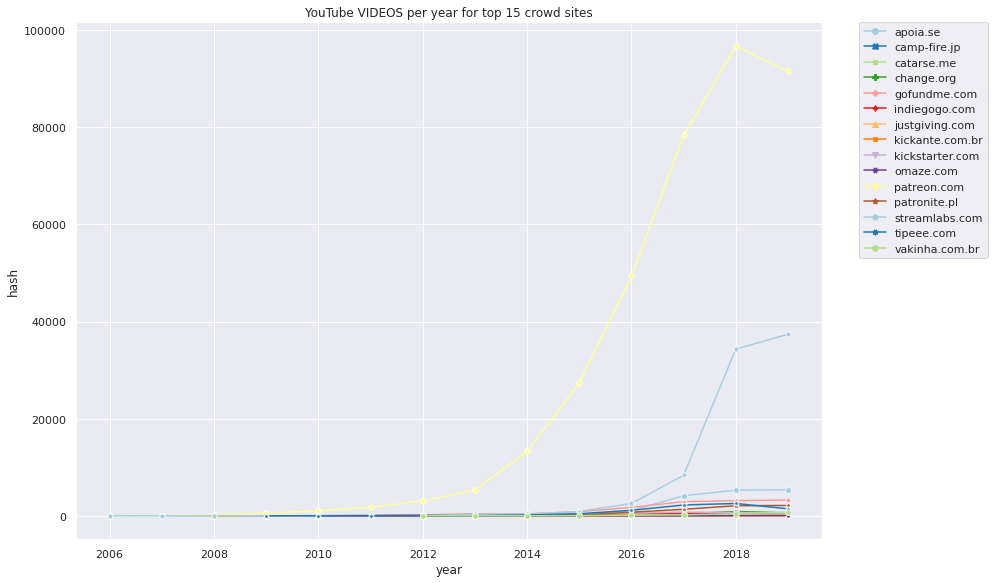

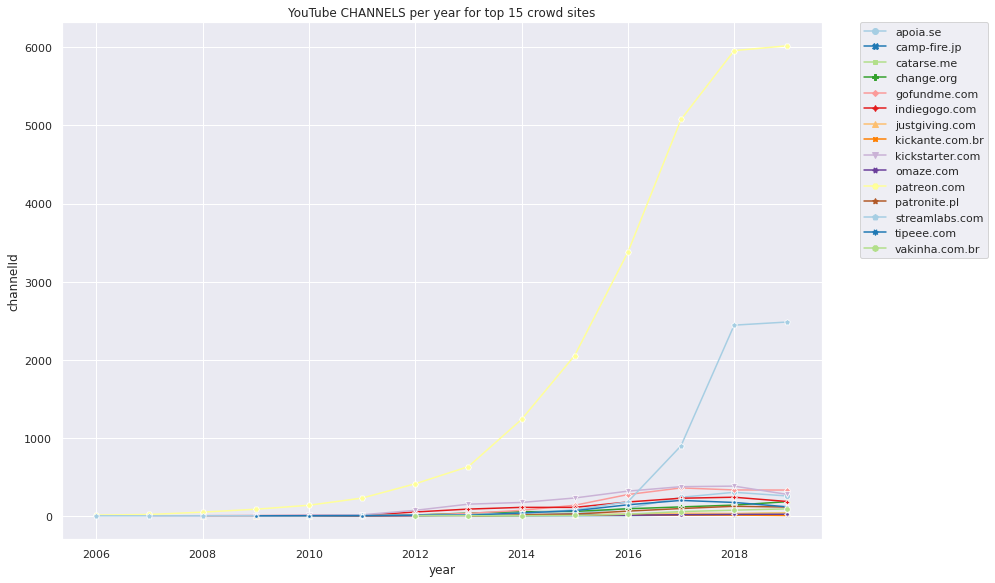

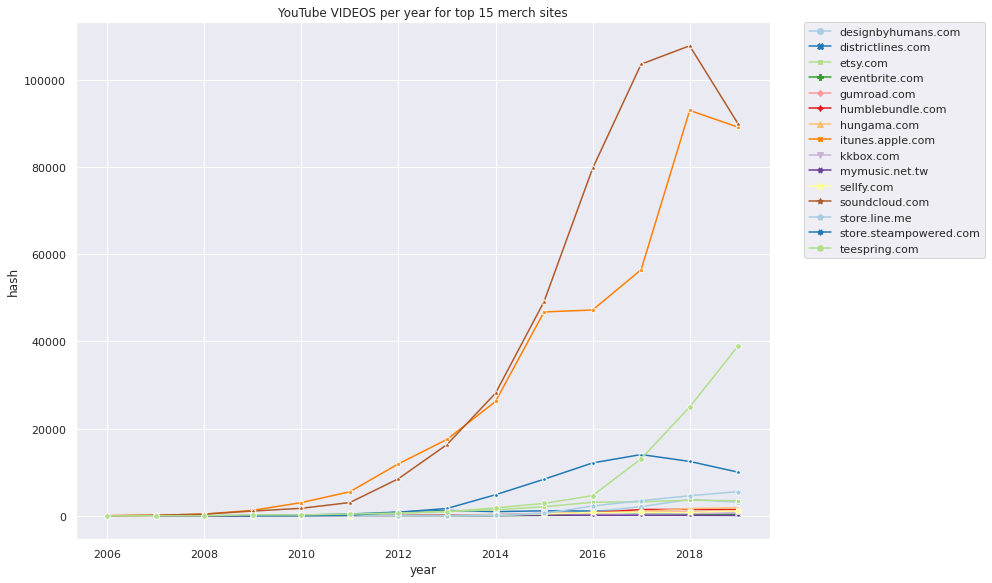

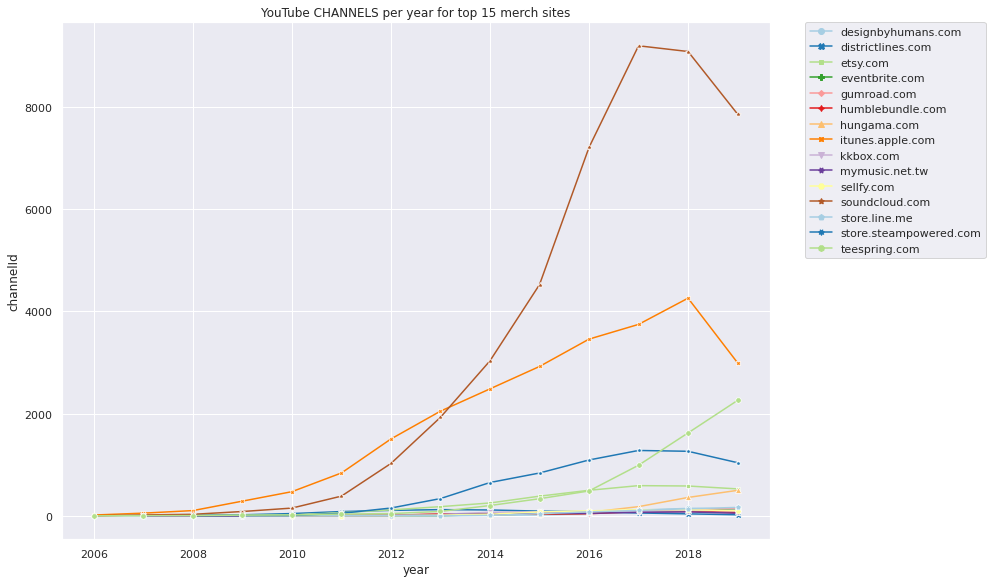

In [25]:
domain_stats = {}
for type in ['crowd','merch']:

    ''' Describe '''
    domain_stats[type] = pd_url_data[['domain','channelCountForDomain','videoCountForDomain','channelDivVideoForDomain']][pd_url_data[type]==True].drop_duplicates()

    # print header
    print("%s domain count" % type)
    # print most used TYPE domains
    print(domain_stats[type].sort_values(by=['channelCountForDomain','channelDivVideoForDomain'],ascending=False).head(limit))
    print("\n")
    # print TYPE domain stats
    print("%s domain stats" % type)
    print(domain_stats[type].describe())
    print("\n")

    ''' Graph '''

    # filter pd_url_data to only retain info for rows with TYPE domain
    filtered = {}
    filtered[type] = pd_url_data[pd_url_data[type]==True]

    # limit data by top overall TYPE domain for graph
    top_domains = {}
    top_domains[type] = domain_stats[type].sort_values(by="channelCountForDomain",ascending=False)['domain'][0:limit]
    filtered_limited = {}
    filtered_limited[type] = filtered[type][filtered[type]['domain'].isin(top_domains[type])==True]

    # get number of unique domains for color palette in graph 
    num_domains = {}
    num_domains[type] = len(filtered_limited[type]['domain'].unique())
    color_palette = {}
    color_palette[type] = sns.color_palette("Paired",n_colors=num_domains[type])

    # count videos by TYPE domain and year
    filtered_limited_count = {}
    filtered_limited_count[type] = filtered_limited[type].groupby(["domain","year"])['hash'].nunique()
    filtered_limited_count[type] = filtered_limited_count[type].to_frame()
    filtered_limited_count[type].reset_index(inplace=True)
    
    # plot rise of TYPE sites, for videos per year
    plt.figure()
    sns.lineplot(x="year", y="hash", hue="domain", style="domain", palette = color_palette[type], markers=True, dashes=False, data=filtered_limited_count[type])
    plt.title("YouTube VIDEOS per year for top %s %s sites" % (limit,type))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

    # count channels by TYPE domain and year
    filtered_limited_count = {}
    filtered_limited_count[type] = filtered_limited[type].groupby(["domain","year"])['channelId'].nunique()
    filtered_limited_count[type] = filtered_limited_count[type].to_frame()
    filtered_limited_count[type].reset_index(inplace=True)

    # plot rise of TYPE sites, for channels per year
    plt.figure()
    sns.lineplot(x="year", y="channelId", hue="domain", style="domain", palette = color_palette[type], markers=True, dashes=False, data=filtered_limited_count[type])
    plt.title("YouTube CHANNELS per year for top %s %s sites" % (limit,type))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()


## @todo

* Work on the referral list
   * Observations
      * not all monetization sites are part of our list getshirts.de
      * Stuff definitely missing on our lists: getshirts.de, amazon.{tld}, banggood, aliexpress, skillshare, …
   * √ Get 1000 domains of all URLs (overall and based on channel)
      * √ Already qualify as crowd, merch, commission
      * Continue the rest of the sites and see whether they should be included or added to (other) list via emergent (grounded theory) coding
   * host (instead of domain)
* Overall observations
   * Background graph: number of URLs per year
   * Make RankFlow of top domains per year
   * How many domains for 80% coverage?
   * Domains, top deep links: add diversity
   * Why are there ⅓ of URLs going to youtube.com and what do they link to (videos, channels?) Are they building a network, just like featuring or subscribing?
* Rather than thinking about URLs, think about views/subscriber numbers.
* Is the presence of other platforms a sign of cross-platform activity?
* Look into the means of production, e.g. free audio
* Other
   * Breakdowns
   * subscriber tier
   * language & locale
   * category (channel & video)
   * year

Channel data set
* Fuse this with channels data set. Finding a way to use the URLs to characterize channels.
   * Channel categories. What hasn't been done at all in the last paper is looking at video categories. That may be done interestingly. Monetization per channel category. Channel classification is not done by video creators. 
	   * b = DataFrame(a.var1.str.split('|').tolist(), index=a.var2).stack()
	   * b = b.reset_index()[[0, 'var2']] # var1 variable is currently labeled 0
	   * b.columns = ['var1', 'var2'] # renaming var1
   * Merch and monetization per channel. When did they introduce this?
   * Whether channels changed merch or crowd-financing, giving that they not backport.
* Compare channel categories vs video categories. (But we need to import mysql database.) Is gonna be important when looking at descriptions and tags and such.
* Think of categories in terms of scatter plots. E.g. crowd funding vs merch and category. Size is number of videos.
* Via topic and/or video categories. E.g. gaming may have a very different URL profile then news/politics. 
* Merch stores with particular topical affinity (e.g. alt-right channels use store X) - alternative ways of classifying youtube. Otherway around: categories that are more suited to crowd-funding than others.

Various
* create list of "commission"
	* Official YT merch list = https://support.google.com/youtube/answer/6083754?hl=en#zippy=%2Clist-of-approved-merchandise-sites
* Domains: open.spotify.com, spotify.com, play.google.com, accounts.google.com, etc. (Does play.google.com has a commission?)

Alternative modes of classification? 
* For a channel we have channel description, keywords, all video titles and keywords. Run as a topic model.
* Video categories are unique and chosen by uploaders
* Channel category column can have several channels, is assigned done automatically by YouTube
* (channels have keywords too, which are much more descriptive. But long-tail, language specific)

Later
* what kind of channels linked to the academic publishers?
* look into what's missing. The "(note-)book" of the dead.
	* https://www.youtube.com/error?src=404
	* unacademy.com/unavailable
* graphs, instead of absolute numbers, divide into number of videos per year
* Patreon pledgers, crowd-funding sites/pledges.
* Collect ASINs. How many different products are being advertised (most popular producst - # videos, #views; youtube as amazon catalogue).
* Each URL may afford something for analysis.
* Cross-language analysis. (Videos have language, channels have country flag). 